In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/BadWizard/anaconda3/envs/theano/lib/python3.5/site-packages/matplotlib/style/core.py:197: UserWarning: In /Users/BadWizard/.matplotlib/stylelib/my_custom_style.mplstyle: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(message)


In [2]:
import pymc3 as pm3

In [5]:
#time to maturity in year
t = [ 0.00274,  0.21096,   0.46027,   0.88219,   1.67397,   3.06849, 5.06301,  7.46027,   9.34795,   11.11507,  15.30685]
t = np.asanyarray(t)
#interest rates.  Bills: simple rates in %/yr; bonds: yield to maturity in %/yr
y  = [ 7.75,     6.835,    6.655,     6.41,      6.215,     6.195, 6.41,     6.755,    7.01,      7.21,      7.325 ]

y = np.asanyarray(y,dtype=float)
y = y/100

In [6]:
thetaStar = [0.081, -0.003, -0.059, 1.697, -0.021, 0.244]
theta = thetaStar

In [7]:
Beta0 = theta[0];
Beta1 = theta[1];
Beta2 = theta[2];
Beta3 = theta[3];
Tau1 = theta[4];
Tau2 = theta[5];

In [10]:
len(t)

11

In [12]:
ZeroRate = np.zeros((len(t),1),dtype=float)

In [13]:
ZeroRate = np.zeros((len(t),1),dtype=float)
for ii,tt in enumerate(t):
    ZeroRate[ii] = Beta0 + Beta1*(1-np.exp(-tt/Tau1))*(Tau1/tt) + Beta2*((1-np.exp(-tt/Tau1))*(Tau1/tt) - np.exp(-tt/Tau1)) + Beta3*((1-np.exp(-tt/Tau2))*(Tau2/tt) - np.exp(-tt/Tau2));


ZeroRate = ZeroRate/100

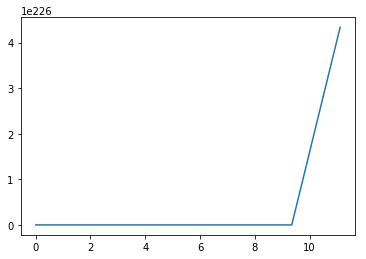

In [14]:
plt.plot(t, ZeroRate)

In [18]:
def svenssonzero(t, theta):
    Beta0 = theta[0];
    Beta1 = theta[1];
    Beta2 = theta[2];
    Beta3 = theta[3];
    Tau1 = theta[4];
    Tau2 = theta[5];
    ZeroRate = np.zeros((len(t),1),dtype=float)
    for ii,tt in enumerate(t):
        ZeroRate[ii] = Beta0 + Beta1*(1-np.exp(-tt/Tau1))*(Tau1/tt) + Beta2*((1-np.exp(-tt/Tau1))*(Tau1/tt) - np.exp(-tt/Tau1)) + Beta3*((1-np.exp(-tt/Tau2))*(Tau2/tt) - np.exp(-tt/Tau2));
    return ZeroRate/100

In [21]:
ZeroRate

array([[  9.14535153e-004],
       [  1.21855582e+001],
       [  1.85444907e+006],
       [  1.00959598e+015],
       [  2.42070946e+031],
       [  1.68347498e+060],
       [  2.98877533e+101],
       [  1.13003984e+151],
       [  1.23560039e+190],
       [  4.33812060e+226],
       [              nan]])

In [19]:
ZeroRate = svenssonzero(t, thetaStar)

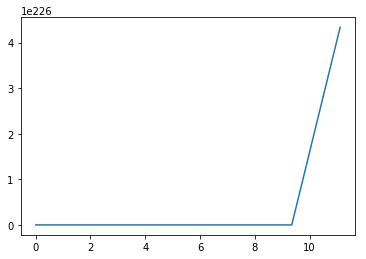

In [20]:
plt.plot(t, ZeroRate)

In [13]:
y = [0.0006,0.0006,0.0009,0.0010,0.0026,0.0056,0.0088,0.0112,0.0144,0.0171,0.0198,0.0244,0.0265,0.0323,0.0337,0.0357,0.0386]
y = np.asanyarray(y,dtype=float)

In [14]:
mu = Beta0 + Beta1*(1-np.exp(-t/Tau1))*(Tau1/t) + Beta2*((1-np.exp(-t/Tau1))*(Tau1/t) - np.exp(-t/Tau1)) + Beta3*((1-np.exp(-t/Tau2))*(Tau2/t) - np.exp(-t/Tau2))

In [15]:
mu

array([ 0.07343039,  0.06536583,  0.07103033,  0.09154936,  0.22058268,
        0.4811666 ,  0.87766571,  1.12589144,  1.44954814,  1.75164898,
        1.962076  ,  2.38421284,  2.58627571,  3.15329506,  3.44673603,
        3.64111504,  3.8036978 ])

In [64]:
with pm3.Model() as model:
    Beta0 = pm3.Flat('b0',testval=thetaStar[0])
    Beta1 = pm3.Flat('b1',testval=thetaStar[1]) 
    Tau1 = pm3.Flat('t1',testval=thetaStar[4])    
    sigma = pm3.Flat('sigma',testval = 0.0017)
    mu = Beta0 + Beta1*(1-np.exp(-t/Tau1))*(Tau1/t)
    like = pm3.Normal('like',mu = mu, sd=sigma, observed=y)

TypeError: bad operand type for unary -: 'list'

In [61]:
with model:
    # obtain MLE 
    beta_mle = pm3.find_MAP()
    # obtain hessian at MAP
    hessian = pm3.approx_hessian(beta_mle)

         Current function value: -49.433268
         Iterations: 50
         Function evaluations: 119
         Gradient evaluations: 100


In [25]:
niter = 55000
with pm3.Model() as model:
    Beta0 = pm3.Normal('b0', mu=thetaStar[0], sd = 10)
    Beta1 = pm3.Normal('b1', mu=thetaStar[1], sd = 10)
    Beta2 = pm3.Normal('b2', mu=thetaStar[2], sd = 100)
    Beta3 = pm3.Normal('b3', mu=thetaStar[3], sd = 100)
    Tau1 = pm3.Normal('t1', mu=thetaStar[4], sd = 10)
    Tau2 = pm3.Normal('t2', mu=thetaStar[4], sd = 10)
    sigma = pm3.HalfCauchy('sigma', 0.1)
    mu = Beta0 + Beta1*(1-np.exp(-t/Tau1))*(Tau1/t) + Beta2*((1-np.exp(-t/Tau1))*(Tau1/t) - np.exp(-t/Tau1)) + Beta3*((1-np.exp(-t/Tau2))*(Tau2/t) - np.exp(-t/Tau2))
    #like = pm3.Normal('like',mu = mu, sd=sigma, observed=y)
    
    
    y_pred = pm3.Normal('y_pred', mu=mu, sd=sigma, observed = y)
    
    start = pm3.find_MAP()
    step = pm3.NUTS(scaling=start)
    trace_mlr = pm3.sample(niter, step=step, start=start )    

         Current function value: -76.980119
         Iterations: 83
         Function evaluations: 184
         Gradient evaluations: 173


100%|██████████| 55500/55500 [2:11:06<00:00,  8.62it/s]  /Users/BadWizard/anaconda3/envs/theano/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/Users/BadWizard/anaconda3/envs/theano/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.881989090369, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



''

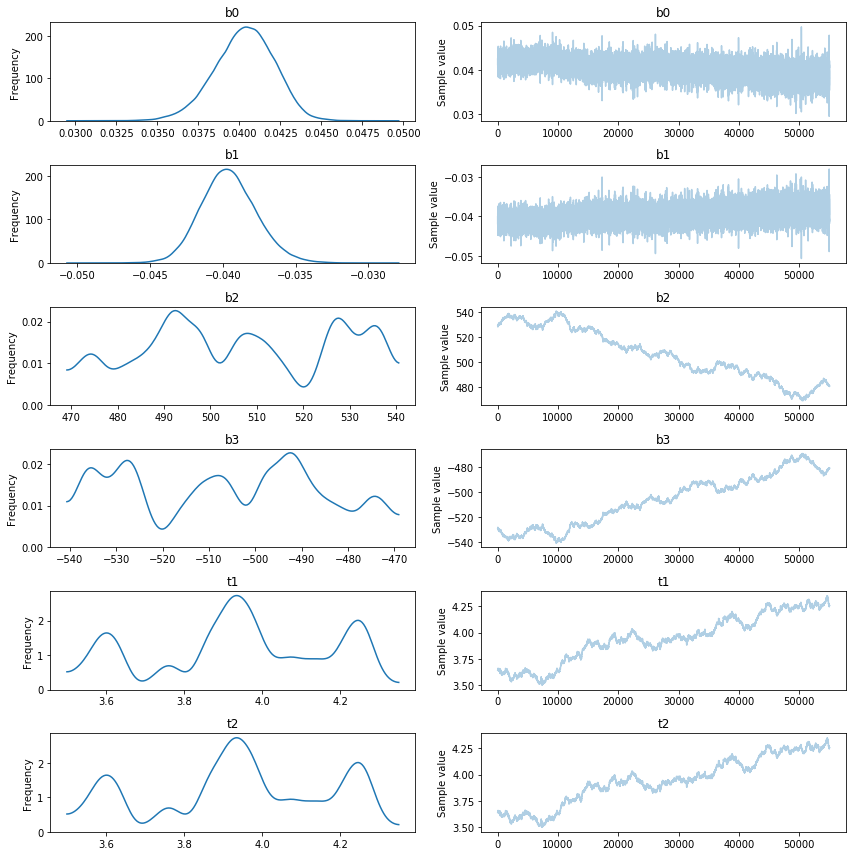

In [26]:
varnames = ['b0','b1', 'b2', 'b3', 't1', 't2']
pm3.traceplot(trace_mlr, varnames)
;

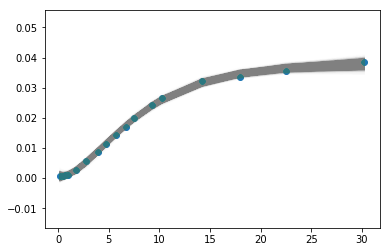

In [27]:
trace = trace_mlr[5001:]
plt.scatter(t, y, label='data')
for b0_, b1_, b2_, b3_, t1_, t2_ in zip(trace['b0'][1:],trace['b1'][1:],trace['b2'][1:],trace['b3'][1:],trace['t1'][1:],trace['t2'][1:]):
    y_ = b0_ + b1_*(1-np.exp(-t/t1_))*(t1_/t) + b2_*((1-np.exp(-t/t1_))*(t1_/t) - np.exp(-t/t1_)) + b3_*((1-np.exp(-t/t2_))*(t2_/t) - np.exp(-t/t2_))
    plt.plot(t, y_, 'grey', alpha=.01)

In [87]:
with model:
    # obtain MLE 
    beta_mle = pm3.find_MAP()
    # obtain hessian at MAP
    hessian = pm3.approx_hessian(beta_mle)

         Current function value: 46.368535
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


In [90]:
beta_mle

{'b0': array(4.189356665823735),
 'b1': array(-4.10020263912661),
 'b2': array(529.8998561476069),
 'b3': array(-531.9001435567558),
 'sigma': array(1.0116400110945676),
 't1': array(3.622370688546624),
 't2': array(3.6179038821803595)}

In [91]:
thetaStar

[4.19, -4.1, 529.9, -531.9, 3.63, 3.61]